アンサンブルをしてもスコアが上がらない。もう一度初心に立ち帰り、特徴量エンジニアリングを行う。

特徴量をチェックするシート

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib

訓練データの読み込み

In [86]:
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')
floor_scores = pd.read_csv('floor_scores.csv')
Floor_scores = pd.read_csv('capital_floor_scores.csv')
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')

rent = pd.read_csv('rent.csv')

テストデータの読み込み

In [87]:
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')

築年数(house_ageについて)

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_6423/2180439461.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


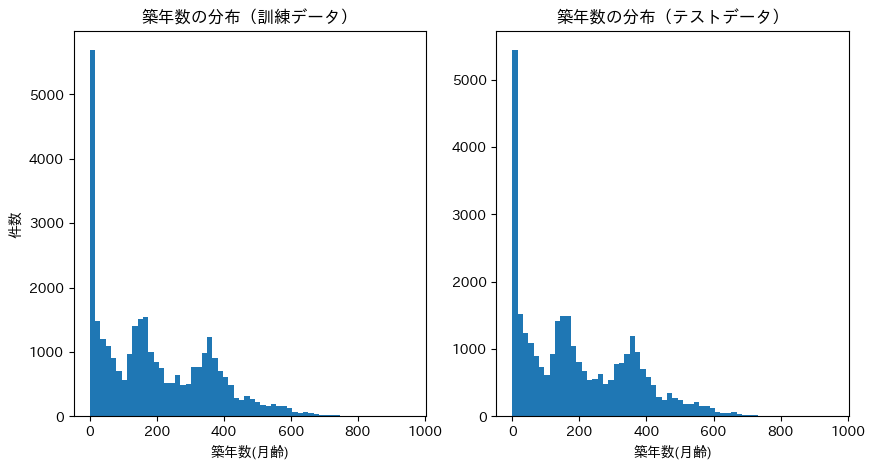

In [88]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(house_age,bins=60)
ax1.set_title('築年数の分布（訓練データ）')
ax1.set_xlabel('築年数(月齢)')
ax1.set_ylabel('件数')

ax2.hist(test_house_age,bins=60)
ax2.set_title('築年数の分布（テストデータ）')
ax2.set_xlabel('築年数(月齢)')

fig.show()

- ここから得られる知見として、築年数ごとの件数でピークがいくつかあるということ。
- 新築の物件が極めて多いこと。

築年数の大きいものが少し怪しい気がするので確かめる。

In [89]:
house_age[house_age['築年数']>800]

築年数
11994  835.0
13755  819.0
15352  955.0
16506  823.0
17090  819.0
21985  830.0
24000  847.0

元データを確認したところ、築800か月(約70年)超えの物件は少ないながら存在しているのでそのままにする。

面積について

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_6423/1120412897.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


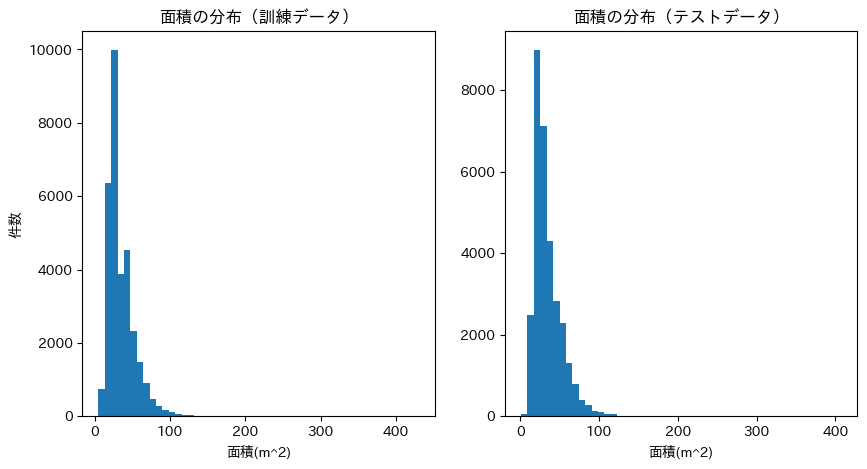

In [90]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(area_size,bins=50)
ax1.set_title('面積の分布（訓練データ）')
ax1.set_xlabel('面積(m^2)')
ax1.set_ylabel('件数')

ax2.hist(test_area_size,bins=50)
ax2.set_title('面積の分布（テストデータ）')
ax2.set_xlabel('面積(m^2)')

fig.show()

面積が大きすぎるものもあるので確認する。

In [91]:
area_size[area_size['面積'] > 200]

面積
671    231.52
1295   214.78
1771   232.01
2075   256.68
5093   217.29
9008   223.71
10334  214.77
11958  221.30
16613  270.07
16847  221.30
18249  259.31
20926  430.10
25951  231.52
30539  341.30

欠損値の処理を見直してみる。

まず自分で欠損値の処理をテキトーにしていた意識があるのは、契約期間である。

In [92]:
contract_span.isna().sum()

契約期間    104
dtype: int64

現在の契約期間データの問題点として、
- 以前は、元ファイルで欠損値になっていたものに0を代入していた。しかしこれでは、モデルに間違った解釈をさせかねない。
- 異常値対策として、契約期間が10年以上のものに対してはnanを代入していた。しかし、例えば1000年のような明らかな異常値はあるものの、15年などのような値も元ファイルに存在している。

これらを修正する。

In [93]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test],axis=0)
merge_contract_span = df["契約期間"]
merge_contract_span.head()

0                       2年間
1                       2年間
2                       2年間
3    2年間\t※この物件は\t定期借家\tです。
4                       2年間
Name: 契約期間, dtype: object

In [94]:
merge_contract_span

0                           2年間
1                           2年間
2                           2年間
3        2年間\t※この物件は\t定期借家\tです。
4                           2年間
                  ...          
31257                       2年間
31258                       NaN
31259    2年間\t※この物件は\t定期借家\tです。
31260                       NaN
31261                       NaN
Name: 契約期間, Length: 62732, dtype: object

In [95]:
merge_contract_span.isna().sum()

14101

In [96]:
i = 0
target = '年'
target2 = 'ヶ'
for s in merge_contract_span:
    #まずはsが欠損値であることに備える。
    try:
        idx = s.find(target)
    except:
        #sが欠損値であればidxの取得が失敗するので、今までは0を代入していた。
        #今回はnanで代入する。
        merge_contract_span[i] = nan
        i += 1
        continue
    
    try:
        #年単位で契約期間が定まっているのかをまず調べる
        merge_contract_span[i] = float( s[:idx] )
    except:
        #月単位で契約期間が定まっているのなら、12で割って契約年数とする。
        idx2 = s.find(target2)
        merge_contract_span[i] = float( s[:idx2] )/12

    try:
        if (merge_contract_span[i] > 30):
            merge_contract_span[i] = nan
    except:
        i += 1
        continue

    i += 1

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_6423/2274210860.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_contract_span[i] = float( s[:idx] )
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_6423/2274210860.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_contract_span[i] = nan
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_6423/2274210860.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [97]:
merge_contract_span.isna().sum()

45461

In [103]:
contract_span2 = merge_contract_span[:len(df_train['契約期間'])]
test_contract_span2 = merge_contract_span[len(df_train['契約期間']):]

In [104]:
contract_span2

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
31465    2.0
31466    2.0
31467    2.0
31468    2.0
31469    2.0
Name: 契約期間, Length: 31470, dtype: object

In [105]:
contract_span2.isna().sum()

7121

In [107]:
test_contract_span2 = test_contract_span2[:len(df_test['契約期間'])]

In [118]:
test_contract_span2 = pd.DataFrame(test_contract_span2)

In [119]:
test_contract_span2

契約期間
0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
...    ...
31257  2.0
31258  2.0
31259  2.0
31260  2.0
31261  2.0

[31262 rows x 1 columns]

In [125]:
test_contract_span2.max()

契約期間    2024.0
dtype: object

In [128]:
test_contract_span2[test_contract_span['契約期間'] < 1.0]

契約期間
0      2.0
15     2.0
19     2.0
26     2.0
28     2.0
...    ...
31255  NaN
31256  NaN
31258  2.0
31260  2.0
31261  2.0

[6994 rows x 1 columns]

In [108]:
test_contract_span2.isna().sum()

7078

In [ ]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('BGL_result.csv',index=False)